# Preprocessing and Tokenization

Rodrigo Becerra Carrillo

https://github.com/bcrodrigo

# Introduction

Notebook to perform Preprocessing and Tokenization on a reviews dataset of Amazon foods.

The dataset was sourced from [here](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data).

## Data Dictionary


| Column Name            | Description                                                               | Data Type |
| ---------------------- | ------------------------------------------------------------------------- | --------- |
| Id                     | Row ID                                                                    | int64     |
| ProductId              | Unique identifier for Product                                             | object    |
| UserId                 | Unique identifier for User                                                | object    |
| ProfileName            | Profile name of the user                                                  | object    |
| HelpfulnessNumerator   | Number of users who found the review helpful                              | int64     |
| HelpfulnessDenominator | Number of users who indicated wether they found the review helpful or not | int64     |
| Score                  | Rating between 1 and 5                                                    | int64     |
| Time                   | Timestamp for the review                                                  | int64     |
| Summary                | Brief summary of the review                                               | object    |
| Text                   | Full review                                                               | object    |


Previously, we performed EDA and noticed there were no missing values, and that there was a class imbalance in the `Score`. From the table above, we'll only use `Text` and `Score` as features and target variable, respectively.

## Import Custom Modules

In [1]:
import sys
sys.path

['/Users/rodrigo/anaconda3/envs/nlp_env/lib/python311.zip',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages']

In [2]:
sys.path.append('..')

In [3]:
from src.preprocessing import preprocess_dataset

In [4]:
preprocess_dataset?

Signature: preprocess_dataset(csv_filename, rebalance=True)
Docstring:
Function to preprocess a reviews datascet in csv into a dataframe with score and text.

Parameters
----------
csv_filename : str
    Path to the csv file containing the data. Note the file is expected to be compressed using gzip.

rebalance : bool, optional
    Optional flag indicates to balance the number of reviews.

Returns
-------
tuple
    Pandas DataFrames (df_orig, df_rebalanced), each with two columns: text and review score.

    if rebalance is False
        df_orig : contains all records
        df_rebalanced : is an empty dataframe

    if rebalance is True
        df_orig : contains all records minus those used to rebalance the review score
        df_rebalanced : contains all records used to balanced number of reviews by score

    Note that in either case pd.concat([df_orig,df_rebalanced]) equals to all the records in the original dataset.
File:      ~/Documents/Github/nlp_reviews/src/preprocessing.py


# Import Libraries and Load DataFrame

In [5]:
import numpy as np
import pandas as pd

In [6]:
file_path = '../data/Reviews.csv.gz'

In [7]:
dforig, dfnew = preprocess_dataset(file_path,rebalance=True)

In [8]:
dforig.shape

(440534, 2)

In [9]:
dfnew.shape

(127920, 2)

In [10]:
dfnew.shape[0] + dforig.shape[0]

568454

In [11]:
dfnew['Score'].value_counts()

Score
0    42640
1    42640
2    42640
Name: count, dtype: int64

In [12]:
dforig['Score'].value_counts()

Score
2    401137
0     39397
Name: count, dtype: int64

# Tokenization

In this section we'll tokenize the contents of `dfnew`. The intent will be to use the Bag-of-Words model with Scikit-Learn.

We need to:

1. Use spaCy to define a custom tokenizer that removes punctuation, stop words, and performs lemmatization
2. Instantiate a `CountVectorizer` and pass custom tokenizer
3. Figure out what is the minimum document frequency for the tokens

## Testing the custom tokenizer

In [13]:
# get the first 5 reviews of the dataset
dftest = dfnew['Text'].head()
first5_rev = dftest.values.tolist()

In [14]:
import spacy

def custom_tokenizer(sentence):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(sentence)

    token_list = [token.lemma_ 
                  for token in doc 
                  if not token.is_punct 
                  and not token.is_stop 
                  and not token.is_space 
                  and not token.is_digit 
                  and not token.is_currency
                 ]

    return token_list

In [15]:
# tokenizer
custom_tokenizer(first5_rev[0])

['drink',
 'lot',
 'sugar',
 'free',
 'beverage',
 'terrible',
 'brew',
 'cup',
 'smell',
 'like',
 'melt',
 'butter',
 'taste',
 'good',
 'waste',
 'money']

In [16]:
# show the full review
print(first5_rev[0])

I drink a lot of sugar-free beverages, but these are TERRIBLE. When you brew the cup, it smells like melted butter and the taste is not good at all. I wouldn't waste your money.


In [17]:
custom_tokenizer(first5_rev[3])

['spend',
 'thinking',
 'dog',
 'entertain',
 'little',
 'minute',
 'remove',
 'treat',
 'ball',
 'happily',
 'munch',
 'away',
 'love',
 'treat',
 'defeat',
 'concept',
 'worth']

In [18]:
print(first5_rev[3])

Spent $20 thinking this would keep my dog entertained for a little while.  Within a few minutes she had removed the treat from the ball and was happily munching away on it.  She loved the treat but defeated the whole concept.  Not worth my $20.


## Test the Count Vectorizer

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
bagofwords = CountVectorizer(tokenizer=custom_tokenizer)
bagofwords.fit(first5_rev)

first5_rev_transformed = bagofwords.transform(first5_rev)
first5_rev_transformed.shape

(5, 138)

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def top_words(Xtransf,bagofwords,num_words=20):
    assert isinstance(num_words,int),"num_words must be an integer"
    
    word_counts = pd.DataFrame(
        {"counts": Xtransf.toarray().sum(axis=0)},
        index = bagofwords.get_feature_names_out()).sort_values("counts", ascending=False)

    word_counts.head(num_words).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title(f"Top {num_words} most frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

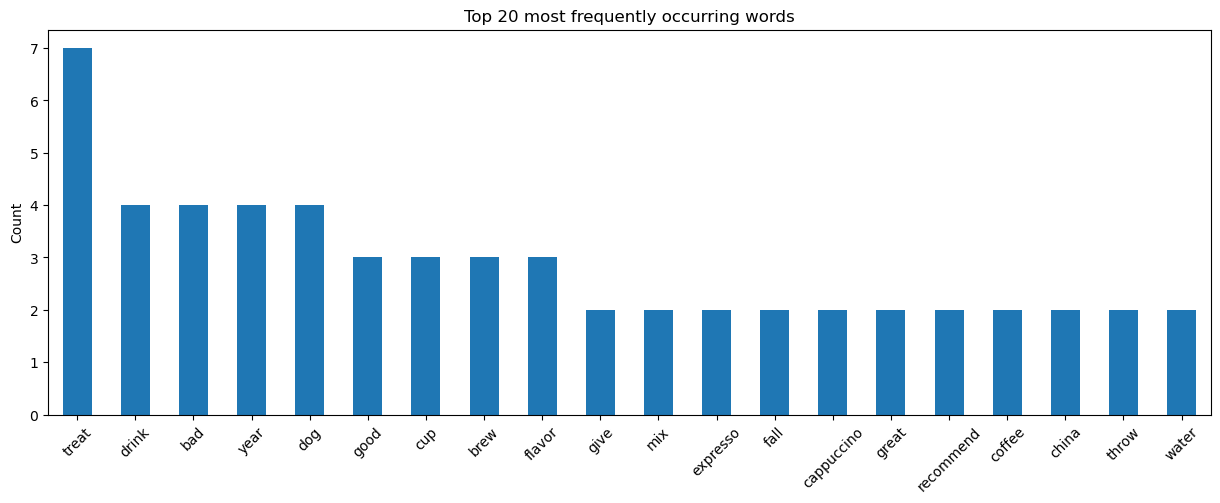

In [32]:
top_words(first5_rev_transformed,bagofwords,20)

# Checking for the minimum document frequency

Now we'll add a large portion of the reviews into the tokenization pipeline

In [33]:
from sklearn.model_selection import train_test_split

In [61]:
def small_sample(dfnew,fraction):
    # fraction = 0.1
    
    acc = pd.DataFrame()
    
    avail_score = dfnew['Score'].value_counts().index
    
    for score in avail_score:
        tempdf = dfnew.query(f'Score == {score}').sample(frac = fraction, random_state = 10).copy()
    
        acc = pd.concat([acc,tempdf], axis = 0)
    
    return acc

In [62]:
df_downsampled = small_sample(dfnew,0.1)

In [69]:
df_downsampled.shape

(12792, 2)

In [63]:
df_downsampled['Score'].value_counts()

Score
0    4264
1    4264
2    4264
Name: count, dtype: int64

In [64]:
# # extract the values from `dfnew` dataframe
# X = dfnew['Text']
# y = dfnew['Score'].values

In [65]:
# extract the values from `df_downsampled` dataframe
X = df_downsampled['Text']
y = df_downsampled['Score'].values

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 10,stratify = y)

In [68]:
X_train.shape[0] + X_test.shape[0]

12792

In [70]:
X.shape

(12792,)

In [71]:
X_train.shape

(10233,)

In [74]:
import spacy
nlp = spacy.load("en_core_web_sm")

def custom_tokenizer2(sentence):
    
    doc = nlp(sentence)

    token_list = [token.lemma_ 
                  for token in doc 
                  if not token.is_punct 
                  and not token.is_stop 
                  and not token.is_space 
                  and not token.is_digit 
                  and not token.is_currency
                 ]

    return token_list

In [91]:
bagofwords = CountVectorizer(tokenizer=custom_tokenizer2,
                             min_df = 0.1
                            )


In [92]:
bagofwords.fit(X_train.sample(frac = 0.3))

CountVectorizer(min_df=0.1,
                tokenizer=<function custom_tokenizer2 at 0x30ed03600>)

In [93]:
X_train_transformed = bagofwords.transform(X_train.sample(frac = 0.3))
X_train_transformed.shape

(3070, 30)

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

def bottom_words(Xtransf,bagofwords,num_words=20):
    assert isinstance(num_words,int),"num_words must be an integer"
    
    word_counts = pd.DataFrame(
        {"counts": Xtransf.toarray().sum(axis=0)},
        index = bagofwords.get_feature_names_out()).sort_values("counts", ascending=True)

    word_counts.head(num_words).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title(f"Top {num_words} least frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

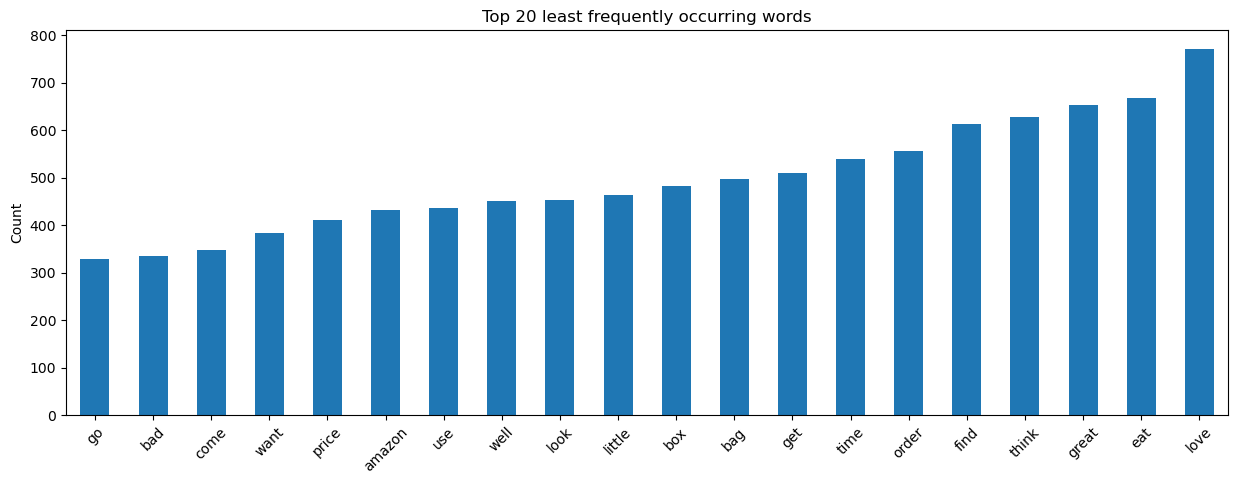

In [95]:
bottom_words(X_train_transformed,bagofwords)

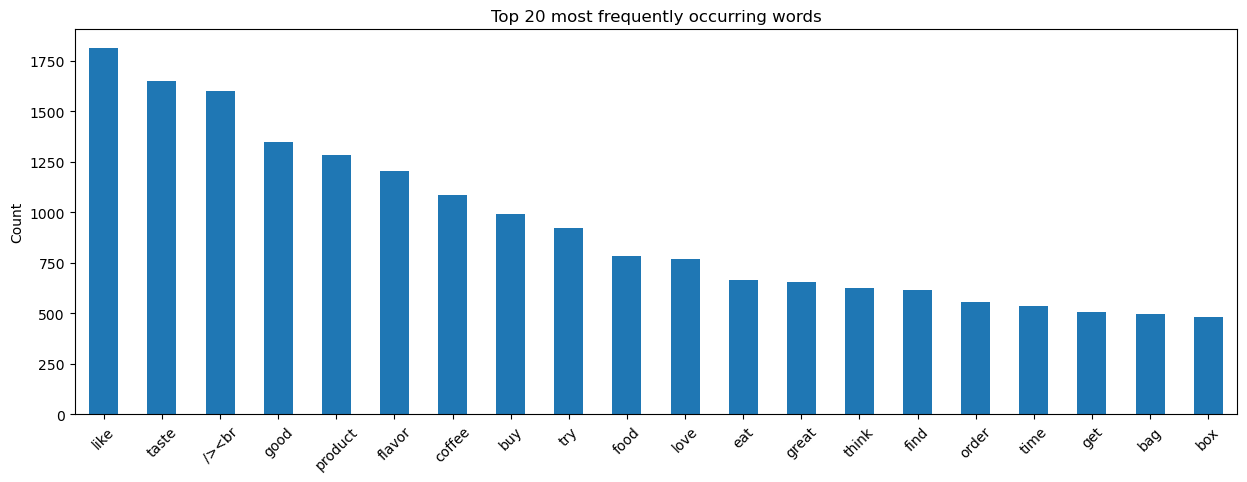

In [96]:
top_words(X_train_transformed,bagofwords)

# Comments and further actions

- We see from the top words that there might be html tags present in the text. We will have to deal with those in the preprocessing prior to tokenization. Perhaps we need a specific text cleanup function.
- Next, we've leanred that the count vectorizer can reasonably handle about 30% of the training data
- We'll need to abstract the top and bottom words plotting function, perhaps in a single function call with two plots